In [1]:
import pandas as pd
import polars as pl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
ptmcode = pl.read_csv("C:/Users/Enrico/OneDrive - UGent/FWO_project/interaction-DBs/PTMcode_any_evidence.csv")
print(ptmcode)

ptmcode_edges = ptmcode.select(
    (pl.col('nodeA') + '--' + pl.col('nodeB')).alias('edge')
)
ptmcode_edges = set(ptmcode_edges['edge'].to_list())
del ptmcode

shape: (4_783_947, 26)
┌──────────┬──────────┬──────────────┬─────────────────┬───┬─────────┬─────────┬──────────────────┬──────────────────┐
│ Protein1 ┆ Protein2 ┆ Species      ┆ PTM1            ┆ … ┆ unimod1 ┆ unimod2 ┆ nodeA            ┆ nodeB            │
│ ---      ┆ ---      ┆ ---          ┆ ---             ┆   ┆ ---     ┆ ---     ┆ ---              ┆ ---              │
│ str      ┆ str      ┆ str          ┆ str             ┆   ┆ i64     ┆ i64     ┆ str              ┆ str              │
╞══════════╪══════════╪══════════════╪═════════════════╪═══╪═════════╪═════════╪══════════════════╪══════════════════╡
│ O43439   ┆ Q01196   ┆ Homo sapiens ┆ phosphorylation ┆ … ┆ 21      ┆ 121     ┆ O43439|588|S|21  ┆ Q01196|215|K|121 │
│ Q01196   ┆ O43439   ┆ Homo sapiens ┆ ubiquitination  ┆ … ┆ 121     ┆ 21      ┆ Q01196|215|K|121 ┆ O43439|588|S|21  │
│ O43439   ┆ Q01196   ┆ Homo sapiens ┆ phosphorylation ┆ … ┆ 21      ┆ 121     ┆ O43439|588|S|21  ┆ Q01196|70|K|121  │
│ Q01196   ┆ O43439   ┆ H

In [3]:
# ptmcode_edges

In [4]:
modpa = pl.read_csv('./compassionate_buck-v2/20251030-1725-compassionate_buck-signed-distances-filtered.csv')
modpa = modpa.with_columns(
    (pl.col('nodeA') + '--' + pl.col('nodeB')).alias('edge'),
)
modpa = modpa.with_columns(
    pl.col('edge').is_in(ptmcode_edges).alias('PTMcode_validated'),
)
print(modpa)

shape: (12_729, 8)
┌─────────────────┬─────────────────┬──────────┬───────┬──────┬──────────┬─────────────────────────┬───────────────────┐
│ nodeA           ┆ nodeB           ┆ distance ┆ Score ┆ pval ┆ adj_pval ┆ edge                    ┆ PTMcode_validated │
│ ---             ┆ ---             ┆ ---      ┆ ---   ┆ ---  ┆ ---      ┆ ---                     ┆ ---               │
│ str             ┆ str             ┆ f64      ┆ f64   ┆ f64  ┆ f64      ┆ str                     ┆ bool              │
╞═════════════════╪═════════════════╪══════════╪═══════╪══════╪══════════╪═════════════════════════╪═══════════════════╡
│ O43399|163|T|21 ┆ Q6SPF0|157|T|21 ┆ 0.67     ┆ 0.67  ┆ 0.0  ┆ 0.0      ┆ O43399|163|T|21--Q6SPF0 ┆ false             │
│                 ┆                 ┆          ┆       ┆      ┆          ┆ |157|T|…                ┆                   │
│ O43663|470|T|21 ┆ P21359|862|T|21 ┆ 0.65     ┆ 0.65  ┆ 0.0  ┆ 0.0      ┆ O43663|470|T|21--P21359 ┆ false             │
│            

In [13]:
modpa2 = modpa.to_pandas()

------

In [15]:
perc_valid_edge = []
for i in np.arange(0.4, 1, .05):
    tmp = modpa2[modpa2.Score >= i]
    tmp = tmp.PTMcode_validated.value_counts()
    valid   = tmp.get(True,0)
    invalid = tmp.get(False,0)
    total   = valid+invalid
    if total > 0:
        perc_valid_edge.append([i,valid/total])
pd.DataFrame(perc_valid_edge, columns=['min_score','percentage'])

,min_score,percentage
0,0.40,0.019954
1,0.45,0.019954
2,0.50,0.019954
3,0.55,0.019954
4,0.60,0.019954
5,0.65,0.019954
6,0.70,0.055279
7,0.75,0.124306
8,0.80,0.185759
9,0.85,0.202614


In [9]:
n_valid_edges = []
for i in np.arange(0.4, 1, .05):
    tmp = modpa.filter(pl.col('Score') >= i)
    tmp2 = tmp['PTMcode_validated'].value_counts()
    tmp2 = tmp2.with_columns(pl.lit(i).alias('min_score'))
    n_valid_edges.append(tmp2)
n_valid_edges = pl.concat(n_valid_edges)
n_valid_edges

PTMcode_validated,count,min_score
bool,u32,f64
false,12475,0.4
true,254,0.4
true,254,0.45
false,12475,0.45
false,12475,0.5
…,…,…
false,122,0.85
true,12,0.9
false,54,0.9


<Axes: xlabel='min_score', ylabel='count'>

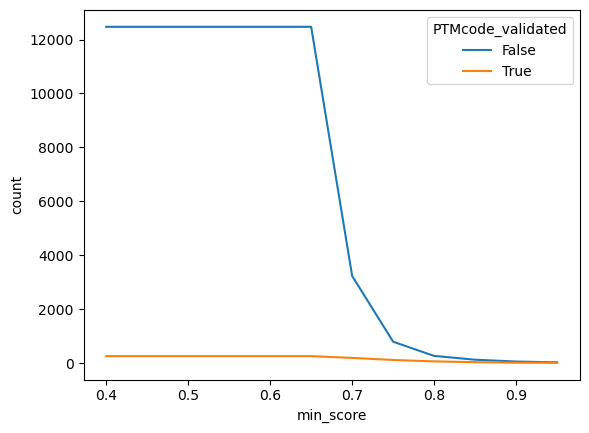

In [11]:
sns.lineplot(data=n_valid_edges, x='min_score', y='count', hue='PTMcode_validated')